<a href="https://colab.research.google.com/github/LeonGoergen/informationExtraction/blob/main/ner/legal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://huggingface.co/docs/transformers/tasks/token_classification

# Dependencies

In [ ]:
from numba import cuda

device = cuda.get_current_device()
device.reset()

In [ ]:
from huggingface_hub import login
login(token="hf_gqwmWYqkoAMZsuraWMUycINzNzOusuhLDcX")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## Installations

In [ ]:
!pip install datasets
!pip install evaluate
!pip install seqeval
!pip install transformers[torch]
!pip install scikit-metrics
!pip install sacremoses

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=348f6d7b8aba5a675b1aa24207ffd2828cbc758b30ea9c4eb903ba102f10fb17
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
  Preparing metadata (setup.py) ... done
  C

In [ ]:
exit(0)

## Imports

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments, pipeline, DataCollatorForTokenClassification
import datasets
from datasets import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from collections import Counter
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data

In [ ]:
train = pd.read_json('/content/drive/MyDrive/Masterarbeit/Datasets/train.json')
test = pd.read_json('/content/drive/MyDrive/Masterarbeit/Datasets/test.json')

len(train), len(test)

(17946, 3167)

In [ ]:
unique_tags = set()
for tags in train['ner_tags']:
  for tag in tags:
    unique_tags.add(tag)

labels_to_ids = {k: v for v, k in enumerate(unique_tags)}
ids_to_labels = {v: k for v, k in enumerate(unique_tags)}

## Classes

In [ ]:
class ModelTrainer():
  def __init__(self, model_name, tokenizer_name, ids_to_labels, labels_to_ids, prefix_space=False, **kwargs):
    self.label_list = [ids_to_labels[i] for i in range(len(labels_to_ids))]
    self.labels_to_ids = labels_to_ids
    self.ids_to_labels = ids_to_labels

    self.model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(self.label_list),
                                                                 id2label=ids_to_labels, label2id=labels_to_ids,
                                                                 ignore_mismatched_sizes=True, **kwargs)
    self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, add_prefix_space=prefix_space)

    if self.tokenizer.pad_token is None:
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model.config.pad_token_id = self.model.config.eos_token_id
        self.model.resize_token_embeddings(len(self.tokenizer))

    self.data_collator = DataCollatorForTokenClassification(self.tokenizer)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.model.to(device)

  def train(self, df, training_args):
    self.__prepare_data(df)

    self.trainer = Trainer(
      model=self.model,
      args=training_args,
      train_dataset=self.train,
      eval_dataset=self.eval,
      tokenizer=self.tokenizer,
      data_collator=self.data_collator,
      compute_metrics=self.__compute_metrics,
    )

    self.trainer.train()

  def save(self, name):
    self.trainer.save_model("/content/" + name + "/final")
    zip_command = f'zip -r "/content/drive/MyDrive/Masterarbeit/Models/ner_{name}.zip" "/content/{name}/final"'
    !{zip_command}

  def evaluate_training(self):
    train_losses = []
    eval_losses = []

    for d in self.trainer.state.log_history:
      if "loss" in d:
        train_losses.append(d["loss"])
      elif "eval_loss" in d:
        eval_losses.append(d["eval_loss"])

    plt.plot(train_losses, label='train')
    plt.plot(eval_losses, label='eval')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show();

  def __prepare_data(self, df):
    train_dataset, eval_dataset = train_test_split(df, test_size=0.15, random_state=1)

    train_hugging = Dataset.from_pandas(train_dataset)
    eval_hugging = Dataset.from_pandas(eval_dataset)

    train_untokenized = train_hugging.map(self.__encode_tags)
    eval_untokenized = eval_hugging.map(self.__encode_tags)

    self.train = train_untokenized.map(self.__tokenize_and_align_labels, batched=True)
    self.eval = eval_untokenized.map(self.__tokenize_and_align_labels, batched=True)

  def __encode_tags(self, examples):
    examples['ner_tags'] = [self.labels_to_ids[tag] for tag in examples['ner_tags']]
    return examples

  def __tokenize_and_align_labels(self, examples):
    tokenized_inputs = self.tokenizer(examples["tokens"], truncation=False, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
      word_ids = tokenized_inputs.word_ids(batch_index=i)
      previous_word_idx = None
      label_ids = []
      for word_idx in word_ids:
        if word_idx is None:
          label_ids.append(-100)
        elif word_idx != previous_word_idx:
          label_ids.append(label[word_idx])
        else:
          label_ids.append(-100)
        previous_word_idx = word_idx
      labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

  def __compute_metrics(self, p):
    seqeval = evaluate.load("seqeval")
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
      [self.label_list[p] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
      [self.label_list[l] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)

    return {
      "precision": results["overall_precision"],
      "recall": results["overall_recall"],
      "f1": results["overall_f1"],
      "accuracy": results["overall_accuracy"],
    }

In [ ]:
class ModelPipe():
  def __init__(self, model_name, tokenizer_name):
    rm_command = f'rm -rf "/content/{model_name}/final"'
    !{rm_command}

    mkdir_command = f'mkdir -p "/content/{model_name}/final"'
    !{mkdir_command}

    unzip_command = f'unzip "/content/drive/MyDrive/Masterarbeit/Models/ner_{model_name}.zip" -d "/content/{model_name}/final"'
    !{unzip_command}

    self.model = AutoModelForTokenClassification.from_pretrained("/content/" + model_name + "/final/content/" + model_name + "/final")
    self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, is_split_into_words=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.model.to(device)

    self.pipe = pipeline("ner", model=self.model, tokenizer=self.tokenizer, aggregation_strategy="max", device=0)

  def inference(self, text):
    result = self.pipe(text)
    return result

  def evaluate(self, df):
    self.all_predictions = []
    self.all_ground_truth = []

    for idx, example in tqdm(df.iterrows(), total=df.shape[0]):
      predictions = pipe.inference(' '.join(example['tokens']))
      tokens = example['tokens']
      ground_truth = example['ner_tags']

      y_pred = self.__align_predictions_with_tokens(predictions, self.__get_token_char_indices(tokens))
      y_true = self.__convert_to_true_entities(ground_truth)

      self.all_predictions.extend(y_pred)
      self.all_ground_truth.extend(y_true)

  def __get_token_char_indices(self, tokens):
    text = ' '.join(tokens)
    token_indices = []
    current_index = 0
    for token in tokens:
      start_index = text.index(token, current_index)
      end_index = start_index + len(token)
      token_indices.append((start_index, end_index))
      current_index = end_index + 1
    return token_indices

  def __convert_to_true_entities(self, ner_tags):
    new_ner_tags = []
    for tag in ner_tags:
      if tag.startswith('B-') or tag.startswith('I-'):
        new_ner_tags.append(tag[2:])
      else:
        new_ner_tags.append(tag)
    return new_ner_tags

  def __align_predictions_with_tokens(self, predictions, token_indices):
    aligned_predictions = ['O'] * len(token_indices)
    for pred in predictions:
      entity_group = pred['entity_group']
      start_char = pred['start']
      end_char = pred['end']
      for i, (start_token, end_token) in enumerate(token_indices):
        if start_token >= start_char and end_token <= end_char:
          aligned_predictions[i] = f'{entity_group}'
        elif start_token <= start_char < end_token or start_token < end_char <= end_token:
          aligned_predictions[i] = f'{entity_group}'
    return aligned_predictions

  def print_classification_report(self):
    labels = list(set(self.all_ground_truth) | set(self.all_predictions))

    if 'O' in labels:
      labels.remove('O')

    report = classification_report(self.all_ground_truth, self.all_predictions, labels=labels, digits=3)
    print(report)

  def print_confusion_matrix(self):
    labels = list(set(self.all_ground_truth) | set(self.all_predictions))

    if 'O' in labels:
        labels.remove('O')

    conf_matrix = confusion_matrix(self.all_ground_truth, self.all_predictions, labels=labels)

    # Normalize the confusion matrix
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.show()

# BERT

In [ ]:
model_name = "bert-base"

##Training

In [ ]:
model = ModelTrainer("bert-base-german-cased", "bert-base-german-cased", ids_to_labels, labels_to_ids)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/485k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<bound method ModelTrainer.__encode_tags of <__main__.ModelTrainer object at 0x799e7641b130>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashi

Map:   0%|          | 0/15254 [00:00<?, ? examples/s]

Map:   0%|          | 0/2692 [00:00<?, ? examples/s]

Map:   0%|          | 0/15254 [00:00<?, ? examples/s]

Map:   0%|          | 0/2692 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
0,No log,0.055836,0.796478,0.861649,0.827783,0.985875
2,0.137300,0.035771,0.879785,0.918801,0.898870,0.991111


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


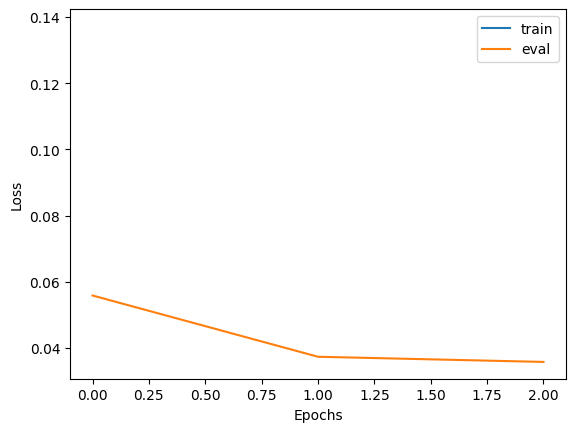

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

updating: content/bert-base/final/ (stored 0%)
updating: content/bert-base/final/model.safetensors (deflated 7%)
updating: content/bert-base/final/tokenizer.json (deflated 71%)
updating: content/bert-base/final/tokenizer_config.json (deflated 75%)
updating: content/bert-base/final/config.json (deflated 63%)
updating: content/bert-base/final/training_args.bin (deflated 51%)
updating: content/bert-base/final/special_tokens_map.json (deflated 42%)
updating: content/bert-base/final/vocab.txt (deflated 57%)


## Inference

In [ ]:
pipe = ModelPipe(model_name, 'bert-base-german-cased')

Archive:  /content/drive/MyDrive/Masterarbeit/Models/ner_bert-base.zip
   creating: /content/bert-base/final/content/bert-base/final/
  inflating: /content/bert-base/final/content/bert-base/final/model.safetensors  
  inflating: /content/bert-base/final/content/bert-base/final/tokenizer.json  
  inflating: /content/bert-base/final/content/bert-base/final/tokenizer_config.json  
  inflating: /content/bert-base/final/content/bert-base/final/config.json  
  inflating: /content/bert-base/final/content/bert-base/final/training_args.bin  
  inflating: /content/bert-base/final/content/bert-base/final/special_tokens_map.json  
  inflating: /content/bert-base/final/content/bert-base/final/vocab.txt  


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/485k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
example_index = 6

print(test.iloc[example_index]['tokens'])
print(test.iloc[example_index]['ner_tags'])
print(pipe.inference(' '.join(test.iloc[example_index]['tokens'])))

['Bei', 'der', 'anschließenden', 'Durchsuchung', 'der', 'Wohnung', 'des', 'Klägers', 'und', 'seiner', 'Eltern', 'wurden', 'diverse', 'mobile', 'Endgeräte', 'und', 'Speicherkarten', 'sichergestellt', 'und', 'der', 'Kläger', 'befragt', '(', 'Polizei', 'Bremen', 'K', '62', 'P', '2', 'Bl.', '48', 'ff.', ',', '53', 'ff.', ')', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-INN', 'I-INN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[{'entity_group': 'INN', 'score': 0.4867369, 'word': 'Polizei Bremen K 62', 'start': 169, 'end': 188}]


In [ ]:
pipe.evaluate(test)

100%|██████████| 3167/3167 [01:05<00:00, 48.56it/s]


In [ ]:
pipe.print_classification_report()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         GRT      0.946     0.962     0.954       417
         MRK      0.800     0.507     0.621        71
          GS      0.997     0.992     0.994      8288
         INN      0.915     0.977     0.945       662
          VO      0.938     0.981     0.959       569
          AN      0.000     0.000     0.000         7
         LIT      0.952     0.972     0.962      1874
         LDS      0.000     0.000     0.000        17
          RR      0.943     0.975     0.959       204
         ORG      0.740     0.644     0.689       177
          ST      0.850     0.810     0.829        63
          UN      0.837     0.917     0.875       168
          VS      0.849     0.888     0.868       489
         EUN      0.934     0.983     0.957       859
          VT      0.959     0.982     0.970      1302
         PER      0.858     0.951     0.902       203
         STR      1.000     0.400     0.571        15
          RS      0.992    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


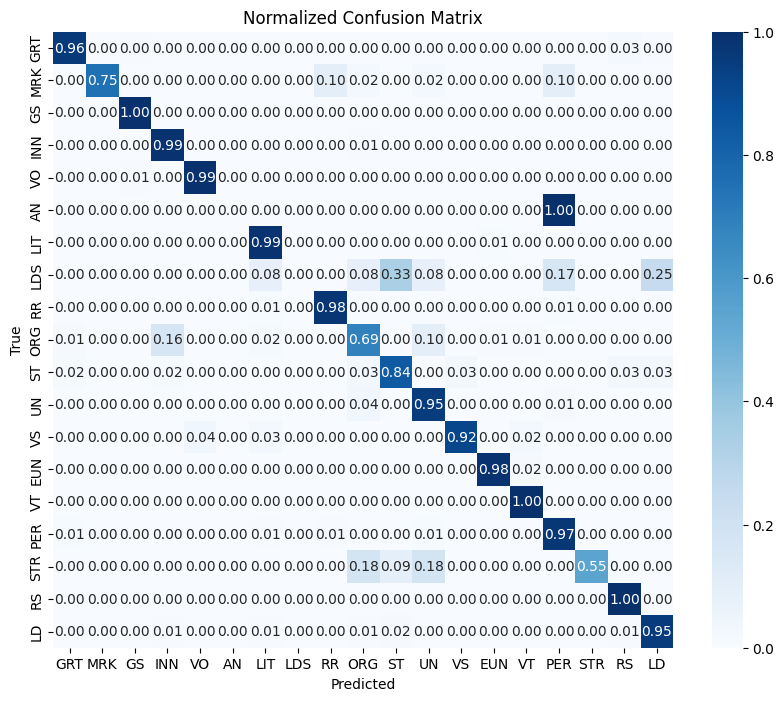

In [ ]:
pipe.print_confusion_matrix()

# RoBERTa

In [ ]:
model_name = "xlm-roberta-base"

##Training

In [ ]:
model = ModelTrainer("FacebookAI/xlm-roberta-base", "FacebookAI/xlm-roberta-base", ids_to_labels, labels_to_ids)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<bound method ModelTrainer.__encode_tags of <__main__.ModelTrainer object at 0x7ce004453880>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashi

Map:   0%|          | 0/15254 [00:00<?, ? examples/s]

Map:   0%|          | 0/2692 [00:00<?, ? examples/s]

Map:   0%|          | 0/15254 [00:00<?, ? examples/s]

Map:   0%|          | 0/2692 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
0,No log,0.122348,0.667483,0.680824,0.674088,0.968183
2,0.234000,0.060891,0.780063,0.852904,0.814859,0.984334


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


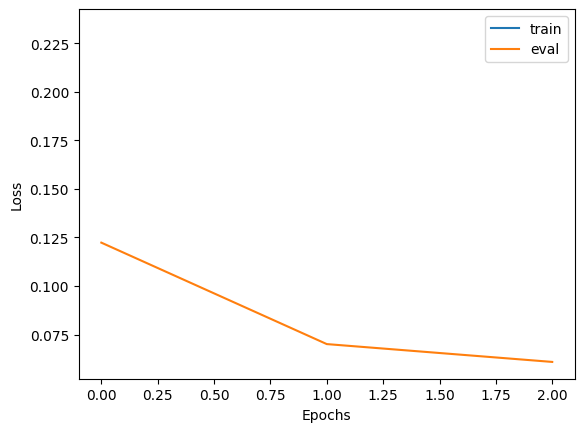

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

  adding: content/xlm-roberta-base/final/ (stored 0%)
  adding: content/xlm-roberta-base/final/model.safetensors (deflated 28%)
  adding: content/xlm-roberta-base/final/tokenizer.json (deflated 76%)
  adding: content/xlm-roberta-base/final/sentencepiece.bpe.model (deflated 49%)
  adding: content/xlm-roberta-base/final/tokenizer_config.json (deflated 76%)
  adding: content/xlm-roberta-base/final/config.json (deflated 62%)
  adding: content/xlm-roberta-base/final/training_args.bin (deflated 51%)
  adding: content/xlm-roberta-base/final/special_tokens_map.json (deflated 52%)


## Inference

In [ ]:
pipe = ModelPipe(model_name, 'FacebookAI/xlm-roberta-base')

Archive:  /content/drive/MyDrive/Masterarbeit/Models/ner_xlm-roberta-base.zip
   creating: /content/xlm-roberta-base/final/content/xlm-roberta-base/final/
  inflating: /content/xlm-roberta-base/final/content/xlm-roberta-base/final/model.safetensors  
  inflating: /content/xlm-roberta-base/final/content/xlm-roberta-base/final/tokenizer.json  
  inflating: /content/xlm-roberta-base/final/content/xlm-roberta-base/final/sentencepiece.bpe.model  
  inflating: /content/xlm-roberta-base/final/content/xlm-roberta-base/final/tokenizer_config.json  
  inflating: /content/xlm-roberta-base/final/content/xlm-roberta-base/final/config.json  
  inflating: /content/xlm-roberta-base/final/content/xlm-roberta-base/final/training_args.bin  
  inflating: /content/xlm-roberta-base/final/content/xlm-roberta-base/final/special_tokens_map.json  


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
print(test.iloc[0]['tokens'])
print(test.iloc[0]['ner_tags'])
print(pipe.inference(' '.join(test.iloc[0]['tokens'])))

['(', '3', ')', 'Anhaltspunkte', 'dafür', ',', 'dass', 'der', 'Teilwert', 'der', 'streitbefangenen', 'Wiederbepflanzungsrechte', 'zum', '30.', 'Juni', '2011', 'unter', 'deren', 'Anschaffungskosten', '(', '§', '6', 'Abs.', '1', 'Nr.', '2', 'Satz', '2', 'EStG', ')', 'gesunken', 'war', ',', 'sind', 'weder', 'vorgetragen', 'noch', 'ersichtlich', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[{'entity_group': 'GS', 'score': 0.9980581, 'word': '§6Abs.1Nr.2Satz2EStG', 'start': 143, 'end': 171}]


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:392: UserWarning: Tokenizer does not support real words, using fallback heuristic
  warnings.warn(


In [ ]:
pipe.evaluate(test)

100%|██████████| 3167/3167 [01:01<00:00, 51.13it/s]


In [ ]:
pipe.print_classification_report()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         GRT      0.921     0.954     0.938       417
         ORG      1.000     0.045     0.086       177
         EUN      0.785     0.993     0.877       859
          LD      0.767     0.887     0.822       141
         LDS      0.000     0.000     0.000        17
          RR      0.917     0.917     0.917       204
          VT      0.843     0.919     0.880      1302
          VS      0.825     0.472     0.601       489
         STR      0.000     0.000     0.000        15
         PER      0.791     0.897     0.841       203
         INN      0.814     0.955     0.879       662
         LIT      0.943     0.972     0.957      1874
          VO      0.709     0.467     0.564       569
          AN      0.000     0.000     0.000         7
          ST      0.722     0.413     0.525        63
          RS      0.987     0.995     0.991     10262
         MRK      0.000     0.000     0.000        71
          GS      0.979    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


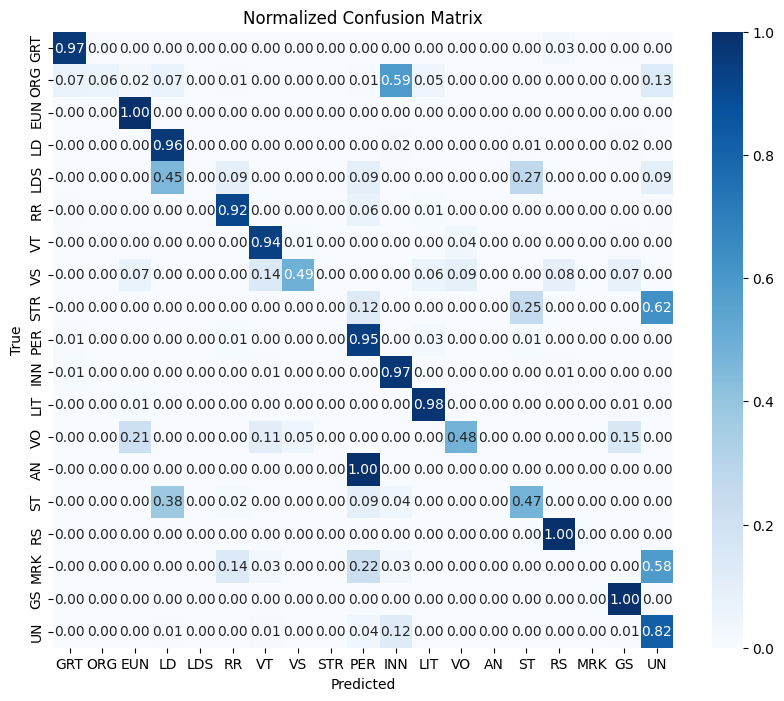

In [ ]:
pipe.print_confusion_matrix()

# ALBERT

In [ ]:
model_name = "albert-base"

##Training

In [ ]:
model = ModelTrainer("ArBert/albert-base-v2-finetuned-ner", "ArBert/albert-base-v2-finetuned-ner", ids_to_labels, labels_to_ids)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

Some weights of AlbertForTokenClassification were not initialized from the model checkpoint at ArBert/albert-base-v2-finetuned-ner and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([9, 768]) in the checkpoint and torch.Size([39, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([39]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/245 [00:00<?, ?B/s]

In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<bound method ModelTrainer.__encode_tags of <__main__.ModelTrainer object at 0x7c23d61eebf0>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashi

Map:   0%|          | 0/15254 [00:00<?, ? examples/s]

Map:   0%|          | 0/2692 [00:00<?, ? examples/s]

Map:   0%|          | 0/15254 [00:00<?, ? examples/s]

Map:   0%|          | 0/2692 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.130088,0.680619,0.700812,0.690568,0.968657
2,0.285700,0.096069,0.758548,0.782948,0.770555,0.977406
3,0.099300,0.081333,0.784196,0.818239,0.800856,0.980854


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


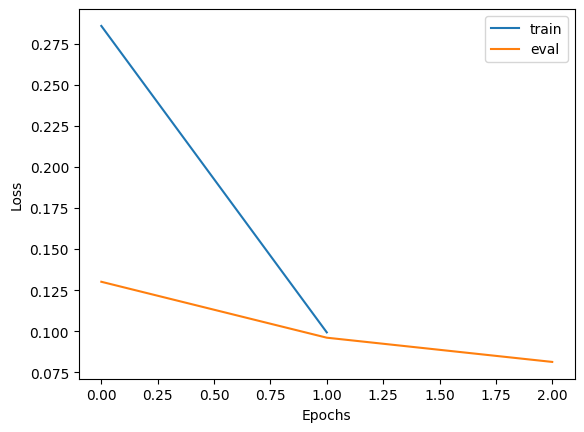

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

  adding: content/albert-base/final/ (stored 0%)
  adding: content/albert-base/final/tokenizer.json (deflated 75%)
  adding: content/albert-base/final/special_tokens_map.json (deflated 84%)
  adding: content/albert-base/final/model.safetensors (deflated 7%)
  adding: content/albert-base/final/training_args.bin (deflated 51%)
  adding: content/albert-base/final/tokenizer_config.json (deflated 74%)
  adding: content/albert-base/final/config.json (deflated 62%)


## Inference

In [ ]:
pipe = ModelPipe(model_name, 'ArBert/albert-base-v2-finetuned-ner')

Archive:  /content/drive/MyDrive/Masterarbeit/Models/ner_albert-base.zip
   creating: /content/albert-base/final/content/albert-base/final/
  inflating: /content/albert-base/final/content/albert-base/final/tokenizer.json  
  inflating: /content/albert-base/final/content/albert-base/final/special_tokens_map.json  
  inflating: /content/albert-base/final/content/albert-base/final/model.safetensors  
  inflating: /content/albert-base/final/content/albert-base/final/training_args.bin  
  inflating: /content/albert-base/final/content/albert-base/final/tokenizer_config.json  
  inflating: /content/albert-base/final/content/albert-base/final/config.json  


In [ ]:
print(test.iloc[0]['tokens'])
print(test.iloc[0]['ner_tags'])
print(pipe.inference(' '.join(test.iloc[0]['tokens'])))

['(', '3', ')', 'Anhaltspunkte', 'dafür', ',', 'dass', 'der', 'Teilwert', 'der', 'streitbefangenen', 'Wiederbepflanzungsrechte', 'zum', '30.', 'Juni', '2011', 'unter', 'deren', 'Anschaffungskosten', '(', '§', '6', 'Abs.', '1', 'Nr.', '2', 'Satz', '2', 'EStG', ')', 'gesunken', 'war', ',', 'sind', 'weder', 'vorgetragen', 'noch', 'ersichtlich', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[{'entity_group': 'GS', 'score': 0.9966322, 'word': '§6abs.1nr.2satz2estg', 'start': 143, 'end': 171}]


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:392: UserWarning: Tokenizer does not support real words, using fallback heuristic
  warnings.warn(


In [ ]:
pipe.evaluate(test)

100%|██████████| 3167/3167 [00:56<00:00, 55.92it/s]


In [ ]:
pipe.print_classification_report()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          VS      0.732     0.603     0.661       489
          ST      0.750     0.095     0.169        63
         LIT      0.893     0.922     0.907      1874
         LDS      0.000     0.000     0.000        17
         EUN      0.925     0.925     0.925       859
          UN      0.790     0.827     0.808       168
          LD      0.806     0.589     0.680       141
         GRT      0.819     0.847     0.833       417
          RS      0.942     0.992     0.966     10262
         STR      0.000     0.000     0.000        15
         PER      0.644     0.759     0.697       203
          AN      0.000     0.000     0.000         7
          VO      0.878     0.606     0.717       569
         INN      0.869     0.869     0.869       662
         MRK      0.000     0.000     0.000        71
          RR      0.949     0.917     0.933       204
          GS      0.962     0.981     0.971      8288
         ORG      0.643    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


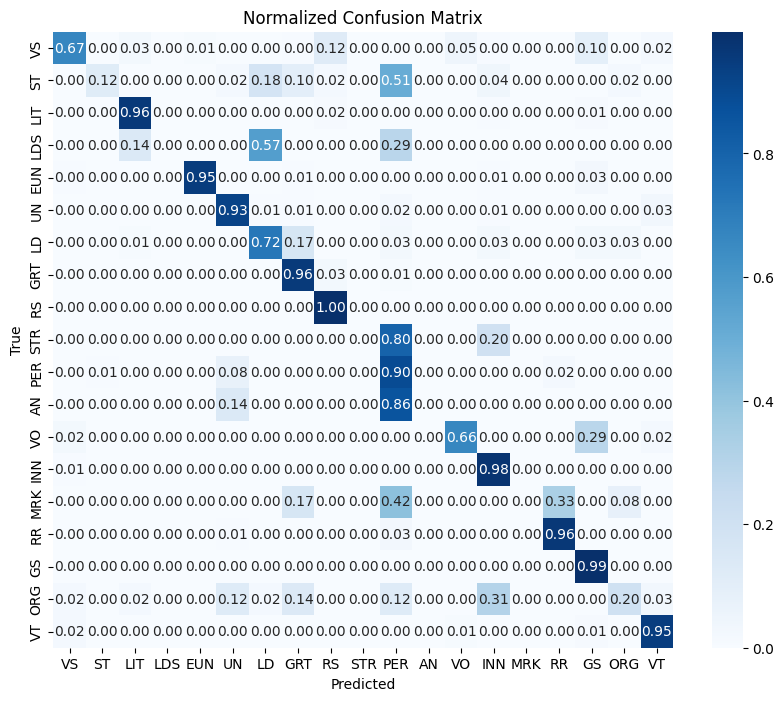

In [ ]:
pipe.print_confusion_matrix()

# GPT-2

In [ ]:
model_name = "gpt2-finetuned"

##Training

In [ ]:
model = ModelTrainer("dbmdz/german-gpt2", "dbmdz/german-gpt2", ids_to_labels, labels_to_ids, prefix_space=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/865 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/510M [00:00<?, ?B/s]

Some weights of GPT2ForTokenClassification were not initialized from the model checkpoint at dbmdz/german-gpt2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer.json:   0%|          | 0.00/1.43M [00:00<?, ?B/s]

In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<bound method ModelTrainer.__encode_tags of <__main__.ModelTrainer object at 0x795d06594040>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashi

Map:   0%|          | 0/15254 [00:00<?, ? examples/s]

Map:   0%|          | 0/2692 [00:00<?, ? examples/s]

Map:   0%|          | 0/15254 [00:00<?, ? examples/s]

Map:   0%|          | 0/2692 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
0,No log,0.218102,0.463189,0.485322,0.473997,0.946386
2,0.468400,0.166817,0.503117,0.579638,0.538674,0.956331


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


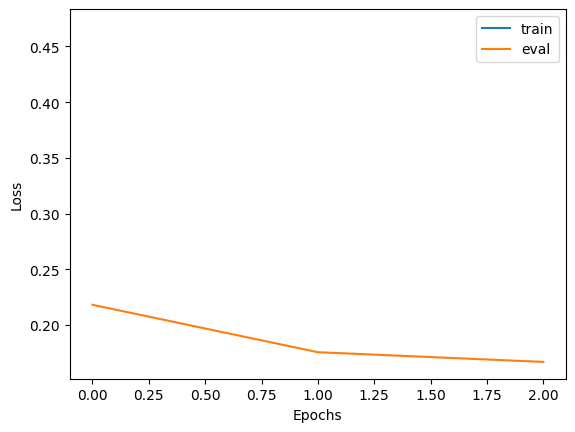

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

  adding: content/gpt2-finetuned/final/ (stored 0%)
  adding: content/gpt2-finetuned/final/merges.txt (deflated 55%)
  adding: content/gpt2-finetuned/final/config.json (deflated 62%)
  adding: content/gpt2-finetuned/final/tokenizer_config.json (deflated 80%)
  adding: content/gpt2-finetuned/final/tokenizer.json (deflated 72%)
  adding: content/gpt2-finetuned/final/model.safetensors (deflated 7%)
  adding: content/gpt2-finetuned/final/vocab.json (deflated 59%)
  adding: content/gpt2-finetuned/final/added_tokens.json (stored 0%)
  adding: content/gpt2-finetuned/final/training_args.bin (deflated 51%)
  adding: content/gpt2-finetuned/final/special_tokens_map.json (deflated 60%)


## Inference

In [ ]:
pipe = ModelPipe(model_name, 'dbmdz/german-gpt2')

Archive:  /content/drive/MyDrive/Masterarbeit/Models/ner_gpt2-finetuned.zip
   creating: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/
  inflating: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/merges.txt  
  inflating: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/config.json  
  inflating: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/tokenizer_config.json  
  inflating: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/tokenizer.json  
  inflating: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/model.safetensors  
  inflating: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/vocab.json  
 extracting: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/added_tokens.json  
  inflating: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/training_args.bin  
  inflating: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/special_tokens_map.json  


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/865 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.43M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
print(test.iloc[0]['tokens'])
print(test.iloc[0]['ner_tags'])
print(pipe.inference(' '.join(test.iloc[0]['tokens'])))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


['(', '3', ')', 'Anhaltspunkte', 'dafür', ',', 'dass', 'der', 'Teilwert', 'der', 'streitbefangenen', 'Wiederbepflanzungsrechte', 'zum', '30.', 'Juni', '2011', 'unter', 'deren', 'Anschaffungskosten', '(', '§', '6', 'Abs.', '1', 'Nr.', '2', 'Satz', '2', 'EStG', ')', 'gesunken', 'war', ',', 'sind', 'weder', 'vorgetragen', 'noch', 'ersichtlich', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[{'entity_group': 'GS', 'score': 0.8388791, 'word': ' § 6 Abs. 1 Nr. 2 Satz 2 EStG', 'start': 142, 'end': 171}]


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:392: UserWarning: Tokenizer does not support real words, using fallback heuristic
  warnings.warn(


In [ ]:
pipe.evaluate(test)

100%|██████████| 3167/3167 [00:38<00:00, 81.21it/s]


In [ ]:
pipe.print_classification_report()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         LIT      0.901     0.867     0.884      1874
          VT      0.677     0.297     0.413      1302
          VS      0.717     0.067     0.123       489
          GS      0.836     0.965     0.896      8288
         STR      0.000     0.000     0.000        15
         ORG      0.000     0.000     0.000       177
         EUN      0.846     0.616     0.713       859
         GRT      0.825     0.624     0.710       417
          AN      0.000     0.000     0.000         7
         PER      0.651     0.276     0.388       203
          RS      0.951     0.973     0.962     10262
         INN      0.822     0.798     0.810       662
          ST      0.000     0.000     0.000        63
          RR      0.895     0.167     0.281       204
          UN      0.787     0.351     0.486       168
          VO      0.600     0.021     0.041       569
         LDS      0.000     0.000     0.000        17
          LD      0.971    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<ipython-input-8-12c73de919b4>:90: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


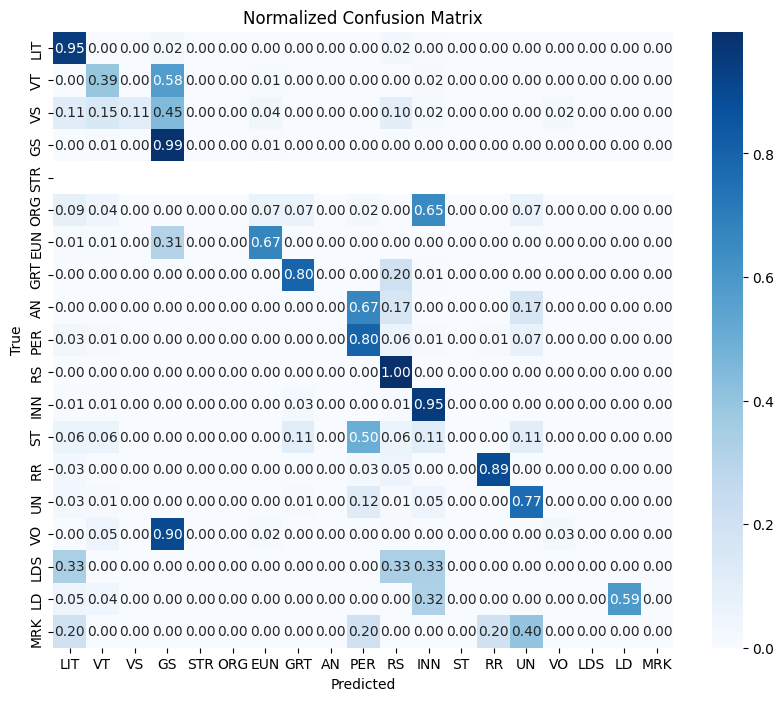

In [ ]:
pipe.print_confusion_matrix()

# GPT-Neo

In [ ]:
model_name = "gpt-neo"

##Training

In [ ]:
model = ModelTrainer("EleutherAI/gpt-neo-125M", "EleutherAI/gpt-neo-125M", ids_to_labels, labels_to_ids, prefix_space=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

Some weights of GPTNeoForTokenClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<bound method ModelTrainer.__encode_tags of <__main__.ModelTrainer object at 0x7ecd663eab30>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashi

Map:   0%|          | 0/15254 [00:00<?, ? examples/s]

Map:   0%|          | 0/2692 [00:00<?, ? examples/s]

Map:   0%|          | 0/15254 [00:00<?, ? examples/s]

Map:   0%|          | 0/2692 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.194893,0.418650,0.532792,0.468875,0.951267
2,0.388900,0.165449,0.444389,0.557776,0.494668,0.958163
3,0.164000,0.157988,0.474887,0.590568,0.526448,0.960178


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


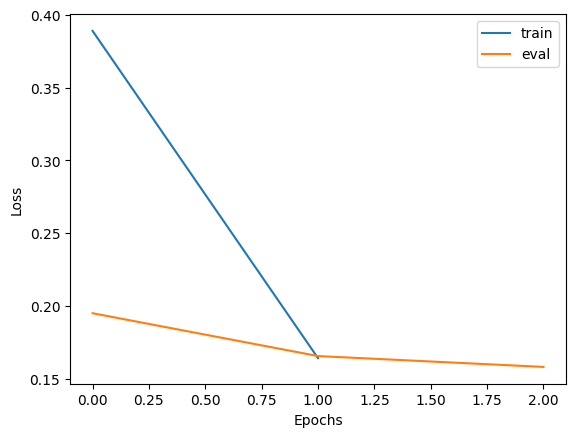

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

  adding: content/gpt-neo/final/ (stored 0%)
  adding: content/gpt-neo/final/merges.txt (deflated 53%)
  adding: content/gpt-neo/final/config.json (deflated 64%)
  adding: content/gpt-neo/final/tokenizer_config.json (deflated 55%)
  adding: content/gpt-neo/final/tokenizer.json (deflated 72%)
  adding: content/gpt-neo/final/model.safetensors (deflated 18%)
  adding: content/gpt-neo/final/vocab.json (deflated 59%)
  adding: content/gpt-neo/final/training_args.bin (deflated 51%)
  adding: content/gpt-neo/final/special_tokens_map.json (deflated 74%)


## Inference

In [ ]:
pipe = ModelPipe(model_name, 'EleutherAI/gpt-neo-125M')

Archive:  /content/drive/MyDrive/Masterarbeit/Models/ner_gpt-neo.zip
   creating: /content/gpt-neo/final/content/gpt-neo/final/
  inflating: /content/gpt-neo/final/content/gpt-neo/final/merges.txt  
  inflating: /content/gpt-neo/final/content/gpt-neo/final/config.json  
  inflating: /content/gpt-neo/final/content/gpt-neo/final/tokenizer_config.json  
  inflating: /content/gpt-neo/final/content/gpt-neo/final/tokenizer.json  
  inflating: /content/gpt-neo/final/content/gpt-neo/final/model.safetensors  
  inflating: /content/gpt-neo/final/content/gpt-neo/final/vocab.json  
  inflating: /content/gpt-neo/final/content/gpt-neo/final/training_args.bin  
  inflating: /content/gpt-neo/final/content/gpt-neo/final/special_tokens_map.json  


tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

In [ ]:
print(test.iloc[0]['tokens'])
print(test.iloc[0]['ner_tags'])
print(pipe.inference(' '.join(test.iloc[0]['tokens'])))

['(', '3', ')', 'Anhaltspunkte', 'dafür', ',', 'dass', 'der', 'Teilwert', 'der', 'streitbefangenen', 'Wiederbepflanzungsrechte', 'zum', '30.', 'Juni', '2011', 'unter', 'deren', 'Anschaffungskosten', '(', '§', '6', 'Abs.', '1', 'Nr.', '2', 'Satz', '2', 'EStG', ')', 'gesunken', 'war', ',', 'sind', 'weder', 'vorgetragen', 'noch', 'ersichtlich', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[{'entity_group': 'GS', 'score': 0.9064714, 'word': ' § 6 Abs. 1 Nr. 2 Satz 2 EStG', 'start': 142, 'end': 171}]


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:392: UserWarning: Tokenizer does not support real words, using fallback heuristic
  warnings.warn(


In [ ]:
pipe.evaluate(test)

100%|██████████| 3167/3167 [01:00<00:00, 52.30it/s]


In [ ]:
pipe.print_classification_report()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         LIT      0.936     0.880     0.907      1874
          AN      0.000     0.000     0.000         7
         STR      0.000     0.000     0.000        15
         LDS      0.000     0.000     0.000        17
         INN      0.860     0.707     0.776       662
         GRT      0.718     0.439     0.545       417
         MRK      0.400     0.028     0.053        71
          VO      0.944     0.207     0.340       569
          LD      0.814     0.340     0.480       141
          GS      0.871     0.945     0.907      8288
          VT      0.742     0.392     0.513      1302
          RR      0.500     0.005     0.010       204
          VS      0.636     0.325     0.430       489
          ST      0.750     0.143     0.240        63
          UN      0.760     0.452     0.567       168
         ORG      0.545     0.068     0.121       177
         EUN      0.859     0.637     0.731       859
          RS      0.963    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


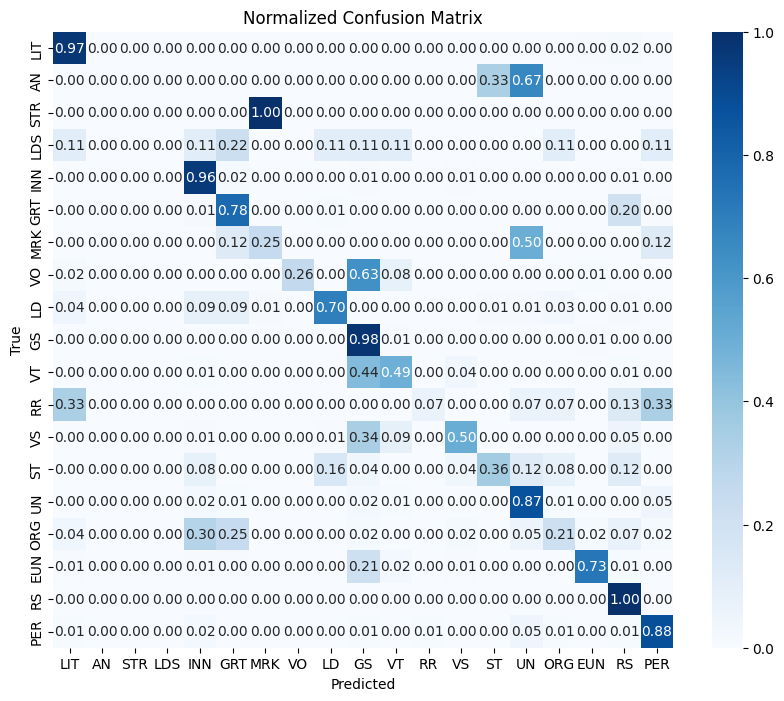

In [ ]:
pipe.print_confusion_matrix()

# T5

In [ ]:
model_name = "google-mt5"

##Training

In [ ]:
model = ModelTrainer("google/mt5-base", "google/mt5-base", ids_to_labels, labels_to_ids)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

Some weights of MT5ForTokenClassification were not initialized from the model checkpoint at google/mt5-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:562: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens match

In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<bound method ModelTrainer.__encode_tags of <__main__.ModelTrainer object at 0x7a0431a67b80>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashi

Map:   0%|          | 0/15254 [00:00<?, ? examples/s]

Map:   0%|          | 0/2692 [00:00<?, ? examples/s]

Map:   0%|          | 0/15254 [00:00<?, ? examples/s]

Map:   0%|          | 0/2692 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.583570,0.093585,0.199563,0.127418,0.881826
2,1.850500,0.355319,0.344433,0.432854,0.383615,0.931905
3,0.581100,0.309352,0.399790,0.475953,0.434559,0.937702


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
There were missing keys in the checkpoint model loaded: ['transformer.encoder.embed_tokens.weight'].


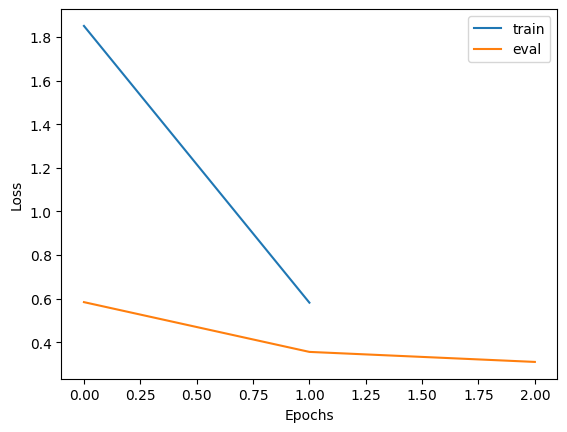

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

  adding: content/google-mt5/final/ (stored 0%)
  adding: content/google-mt5/final/config.json (deflated 61%)
  adding: content/google-mt5/final/tokenizer_config.json (deflated 95%)
  adding: content/google-mt5/final/tokenizer.json (deflated 76%)
  adding: content/google-mt5/final/model.safetensors (deflated 35%)
  adding: content/google-mt5/final/spiece.model (deflated 46%)
  adding: content/google-mt5/final/training_args.bin (deflated 51%)
  adding: content/google-mt5/final/special_tokens_map.json (deflated 73%)


## Inference

In [ ]:
pipe = ModelPipe(model_name, 'google/mt5-base')

Archive:  /content/drive/MyDrive/Masterarbeit/Models/ner_google-mt5.zip
   creating: /content/google-mt5/final/content/google-t5/final/
  inflating: /content/google-mt5/final/content/google-t5/final/training_args.bin  
  inflating: /content/google-mt5/final/content/google-t5/final/config.json  
  inflating: /content/google-mt5/final/content/google-t5/final/tokenizer.json  
  inflating: /content/google-mt5/final/content/google-t5/final/tokenizer_config.json  
  inflating: /content/google-mt5/final/content/google-t5/final/model.safetensors  
  inflating: /content/google-mt5/final/content/google-t5/final/spiece.model  
  inflating: /content/google-mt5/final/content/google-t5/final/special_tokens_map.json  
   creating: /content/google-mt5/final/content/google-t5/final/content/
   creating: /content/google-mt5/final/content/google-t5/final/content/google-t5/
   creating: /content/google-mt5/final/content/google-t5/final/content/google-t5/final/
  inflating: /content/google-mt5/final/conten

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:562: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
print(test.iloc[0]['tokens'])
print(test.iloc[0]['ner_tags'])
print(pipe.inference(' '.join(test.iloc[0]['tokens'])))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


['(', '3', ')', 'Anhaltspunkte', 'dafür', ',', 'dass', 'der', 'Teilwert', 'der', 'streitbefangenen', 'Wiederbepflanzungsrechte', 'zum', '30.', 'Juni', '2011', 'unter', 'deren', 'Anschaffungskosten', '(', '§', '6', 'Abs.', '1', 'Nr.', '2', 'Satz', '2', 'EStG', ')', 'gesunken', 'war', ',', 'sind', 'weder', 'vorgetragen', 'noch', 'ersichtlich', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[{'entity_group': 'GS', 'score': 0.9839681, 'word': '§6Abs.1Nr.2Satz2EStG', 'start': 142, 'end': 171}]


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:392: UserWarning: Tokenizer does not support real words, using fallback heuristic
  warnings.warn(


In [ ]:
pipe.evaluate(test)

100%|██████████| 3167/3167 [01:02<00:00, 50.48it/s]


In [ ]:
pipe.print_classification_report()

              precision    recall  f1-score   support

         STR      0.000     0.000     0.000        15
          GS      0.727     0.949     0.823      8288
          LD      0.110     0.227     0.148       141
         PER      0.000     0.000     0.000       203
         MRK      0.002     0.028     0.004        71
          VT      0.065     0.018     0.029      1302
          ST      0.000     0.000     0.000        63
         GRT      0.149     0.072     0.097       417
          RR      0.018     0.098     0.030       204
         LDS      0.000     0.000     0.000        17
          RS      0.786     0.977     0.871     10262
          VS      0.009     0.012     0.010       489
         LIT      0.456     0.633     0.530      1874
          AN      0.000     0.000     0.000         7
          UN      0.050     0.149     0.075       168
         ORG      0.009     0.011     0.010       177
          VO      0.000     0.000     0.000       569
         INN      0.425    

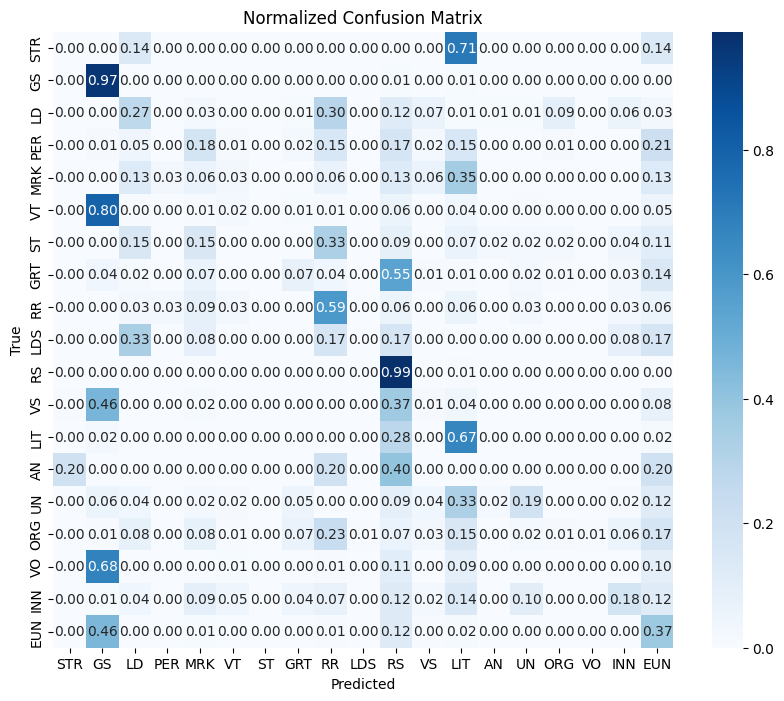

In [ ]:
pipe.print_confusion_matrix()

# XLNet

In [ ]:
model_name = "xlnet-base-cased"

##Training

In [ ]:
model = ModelTrainer("xlnet/xlnet-base-cased", "xlnet/xlnet-base-cased", ids_to_labels, labels_to_ids)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<bound method ModelTrainer.__encode_tags of <__main__.ModelTrainer object at 0x7d0190aa24d0>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashi

Map:   0%|          | 0/15254 [00:00<?, ? examples/s]

Map:   0%|          | 0/2692 [00:00<?, ? examples/s]

Map:   0%|          | 0/15254 [00:00<?, ? examples/s]

Map:   0%|          | 0/2692 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
0,0.288700,0.077003,0.795960,0.849157,0.821698,0.981339
2,0.030700,0.045372,0.892771,0.925671,0.908924,0.989775


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


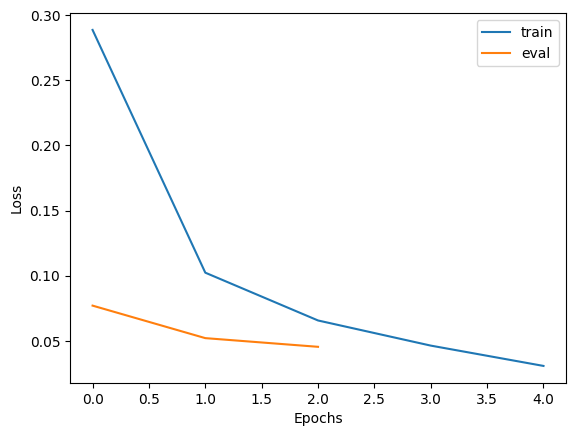

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

updating: content/xlnet-base-cased/final/ (stored 0%)
updating: content/xlnet-base-cased/final/tokenizer_config.json (deflated 81%)
updating: content/xlnet-base-cased/final/tokenizer.json (deflated 75%)
updating: content/xlnet-base-cased/final/training_args.bin (deflated 51%)
updating: content/xlnet-base-cased/final/model.safetensors (deflated 7%)
updating: content/xlnet-base-cased/final/config.json (deflated 62%)
updating: content/xlnet-base-cased/final/spiece.model (deflated 49%)
updating: content/xlnet-base-cased/final/special_tokens_map.json (deflated 52%)


## Inference

In [ ]:
pipe = ModelPipe(model_name, 'xlnet/xlnet-base-cased')

Archive:  /content/drive/MyDrive/Masterarbeit/Models/ner_xlnet-base-cased.zip
   creating: /content/xlnet-base-cased/final/content/xlnet-base-cased/final/
  inflating: /content/xlnet-base-cased/final/content/xlnet-base-cased/final/tokenizer_config.json  
  inflating: /content/xlnet-base-cased/final/content/xlnet-base-cased/final/tokenizer.json  
  inflating: /content/xlnet-base-cased/final/content/xlnet-base-cased/final/training_args.bin  
  inflating: /content/xlnet-base-cased/final/content/xlnet-base-cased/final/model.safetensors  
  inflating: /content/xlnet-base-cased/final/content/xlnet-base-cased/final/config.json  
  inflating: /content/xlnet-base-cased/final/content/xlnet-base-cased/final/spiece.model  
  inflating: /content/xlnet-base-cased/final/content/xlnet-base-cased/final/special_tokens_map.json  


In [ ]:
print(test.iloc[0]['tokens'])
print(test.iloc[0]['ner_tags'])
print(pipe.inference(' '.join(test.iloc[0]['tokens'])))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


['(', '3', ')', 'Anhaltspunkte', 'dafür', ',', 'dass', 'der', 'Teilwert', 'der', 'streitbefangenen', 'Wiederbepflanzungsrechte', 'zum', '30.', 'Juni', '2011', 'unter', 'deren', 'Anschaffungskosten', '(', '§', '6', 'Abs.', '1', 'Nr.', '2', 'Satz', '2', 'EStG', ')', 'gesunken', 'war', ',', 'sind', 'weder', 'vorgetragen', 'noch', 'ersichtlich', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[{'entity_group': 'GS', 'score': 0.9999869, 'word': '', 'start': 143, 'end': 144}, {'entity_group': 'GS', 'score': 0.99435174, 'word': '§6Abs.1Nr.2Satz2EStG', 'start': 143, 'end': 171}]


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:392: UserWarning: Tokenizer does not support real words, using fallback heuristic
  warnings.warn(


In [ ]:
pipe.evaluate(test)

100%|██████████| 3167/3167 [01:27<00:00, 36.01it/s]


In [ ]:
pipe.print_classification_report()

              precision    recall  f1-score   support

          GS      0.976     0.992     0.984      8288
          RS      0.990     0.995     0.992     10262
          AN      0.750     0.857     0.800         7
          VO      0.912     0.837     0.873       569
         EUN      0.971     0.924     0.947       859
          VS      0.876     0.867     0.872       489
         INN      0.904     0.965     0.934       662
         LDS      0.667     0.353     0.462        17
         LIT      0.945     0.958     0.952      1874
          UN      0.852     0.923     0.886       168
         PER      0.806     0.901     0.851       203
          LD      0.897     0.922     0.909       141
         GRT      0.920     0.964     0.941       417
          ST      0.860     0.683     0.761        63
         ORG      0.843     0.638     0.727       177
         MRK      0.724     0.592     0.651        71
          RR      0.965     0.946     0.955       204
          VT      0.940    

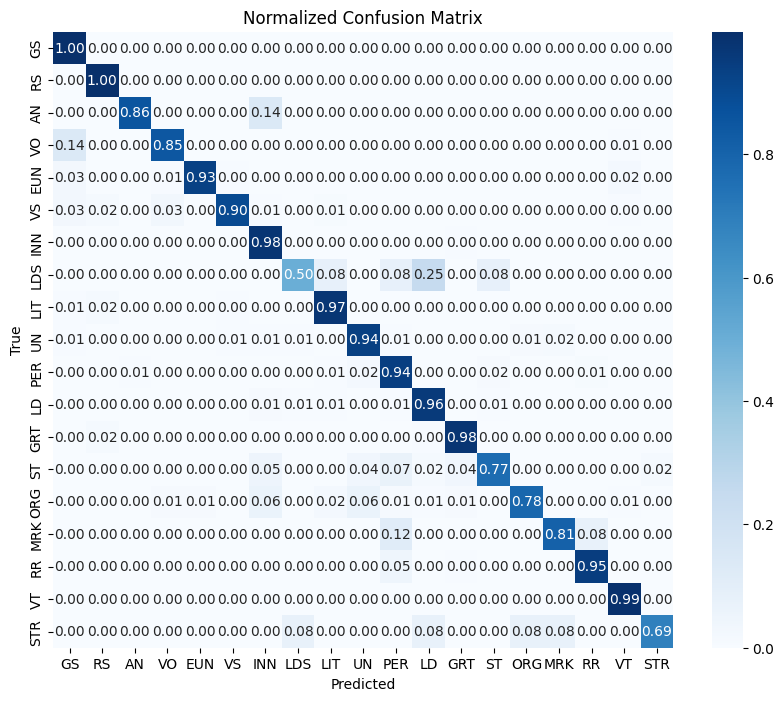

In [ ]:
pipe.print_confusion_matrix()